In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Input
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import random
import tensorflow as tf
from keras.optimizers import Adam


# 设置随机种子
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)
# set_seed(2024)

/root/autodl-tmp/miniconda3/envs/cytf/lib/python3.12/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
2024-07-20 18:41:13.232429: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 18:41:13.233102: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could n

In [2]:
time_steps = 60
forecast_steps = 7

In [3]:

# 读取数据
df = pd.read_csv('/root/autodl-tmp/7.18_SDG预测/data/FB_SDG_3.csv')
data = df.iloc[:, 1].values

# 准备数据
def create_dataset(data, time_steps=1, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps - forecast_steps + 1):
        X.append(data[i:(i + time_steps)])
        y.append(data[(i + time_steps):(i + time_steps + forecast_steps)])
    return np.array(X), np.array(y)


X, y = create_dataset(data, time_steps, forecast_steps)

# 分割数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 标准化数据
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 线性回归
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
lr_pred = lr_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)


# Lasso回归
print("Training Lasso Regression...")
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
lasso_pred = lasso_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

print("Training KNN...")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_pred = np.zeros_like(y_test)
for i in range(y_test.shape[0]):
    input_seq = X_test[i].reshape(1, -1)
    for j in range(forecast_steps):
        knn_model.fit(X_train.reshape(X_train.shape[0], -1), y_train[:, j])
        pred = knn_model.predict(input_seq)
        knn_pred[i, j] = pred[0]  # 确保单个元素的正确分配
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1] = pred[0]  # 确保单个元素的正确分配


# 随机森林
print("Training Random Forest...")
rf_model = RandomForestRegressor()
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
rf_pred = rf_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

# XGBoost
print("Training XGBoost...")
xgb_model = XGBRegressor()
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
xgb_pred = xgb_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

# LSTM
print("Training LSTM...")
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
lstm_model.add(Dense(forecast_steps))
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)
# lstm_model.fit(X_train_lstm, y_train, epochs=30, batch_size=32, verbose=1)
lstm_pred = lstm_model.predict(X_test_lstm).reshape(y_test.shape)


Training Linear Regression...
Training Lasso Regression...
Training KNN...
Training Random Forest...
Training XGBoost...
Training LSTM...
Epoch 1/50


2024-07-20 18:41:40.789793: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/root/autodl-tmp/miniconda3/envs/cytf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 380.6206
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.8738
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.6528
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.3520
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.6062
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.0963
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.9664
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.8117
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.6661
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5299
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.4033
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.2862
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6048066.5000
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 957771.4375
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 14600.522

In [4]:
print("Training GRU...")
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
gru_model = Sequential()
gru_model.add(Input(shape=(time_steps, 1)))
gru_model.add(GRU(50, activation='relu', return_sequences=True))
gru_model.add(GRU(50, activation='relu'))
gru_model.add(Dense(forecast_steps))
optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mse')
gru_model.fit(X_train_gru, y_train, epochs=50, batch_size=32, verbose=1)
gru_pred = gru_model.predict(X_test_gru).reshape(y_test.shape)

Training GRU...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 2.7772
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.2125
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1822
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1740
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1703
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1685
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.1674
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1666
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1660
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1655
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.1650
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1645
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1641
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1637
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - l

In [5]:
# 评估模型
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    return mse, mae

models = {'Linear Regression': lr_pred,  'Lasso Regression': lasso_pred, 'KNN': knn_pred, 'Random Forest': rf_pred, 'XGBoost': xgb_pred, 'LSTM': lstm_pred, 'GRU': gru_pred}
results = {}

for model_name, predictions in models.items():
    mse, mae = evaluate_model(y_test, predictions)
    results[model_name] = {'MSE': mse, 'MAE': mae}

# 转换为DataFrame以便查看
mse_df = pd.DataFrame({model: results[model]['MSE'] for model in results.keys()})
mae_df = pd.DataFrame({model: results[model]['MAE'] for model in results.keys()})

# 计算整体的MSE和MAE
overall_mse = mse_df.mean()
overall_mae = mae_df.mean()

# 显示结果
print("\nMSE for each time step:")
print(mse_df)
print("\nMAE for each time step:")
print(mae_df)

print("\nOverall MSE for each model:")
print(overall_mse)
print("\nOverall MAE for each model:")
print(overall_mae)



MSE for each time step:
   Linear Regression  Lasso Regression       KNN  Random Forest   XGBoost  \
0           0.096050          0.095804  0.203627       0.135074  0.139254   
1           0.140970          0.140367  0.327921       0.182248  0.207823   
2           0.149938          0.149285  0.374742       0.193265  0.225205   
3           0.153645          0.152873  0.327040       0.205808  0.222429   
4           0.157136          0.156255  0.335108       0.211246  0.215135   
5           0.158677          0.158001  0.356578       0.221245  0.235484   
6           0.161253          0.160586  0.348814       0.225118  0.295729   

       LSTM       GRU  
0  0.126508  0.120045  
1  0.154784  0.178821  
2  0.169287  0.198822  
3  0.167388  0.198051  
4  0.166410  0.209103  
5  0.188938  0.198860  
6  0.167371  0.197191  

MAE for each time step:
   Linear Regression  Lasso Regression       KNN  Random Forest   XGBoost  \
0           0.226164          0.226036  0.346723       0.274706 

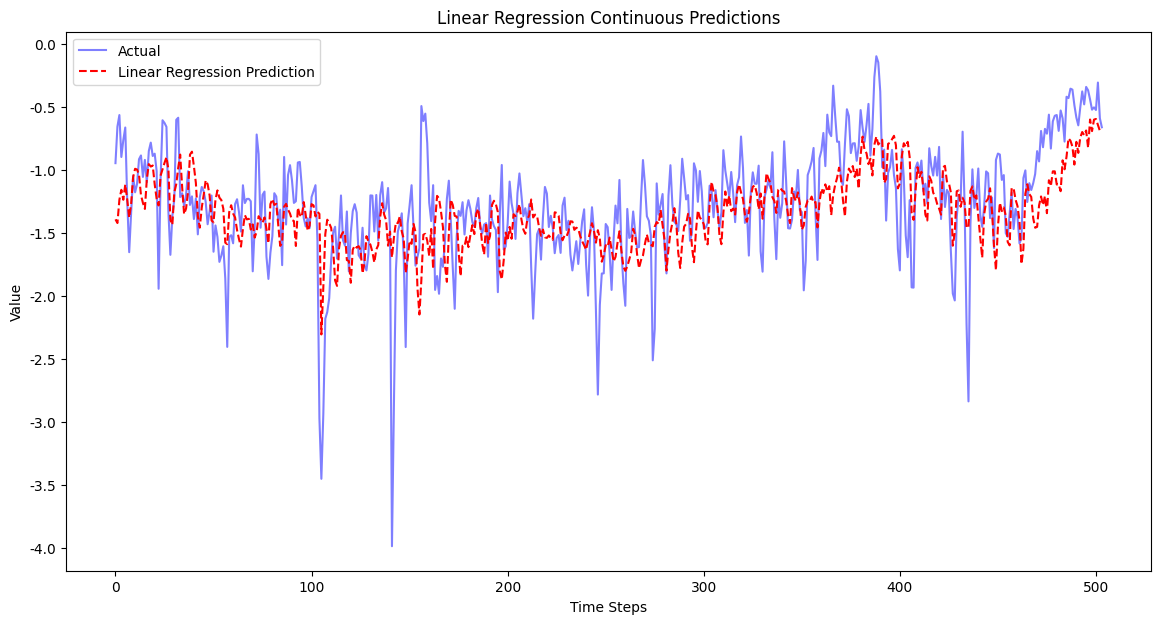

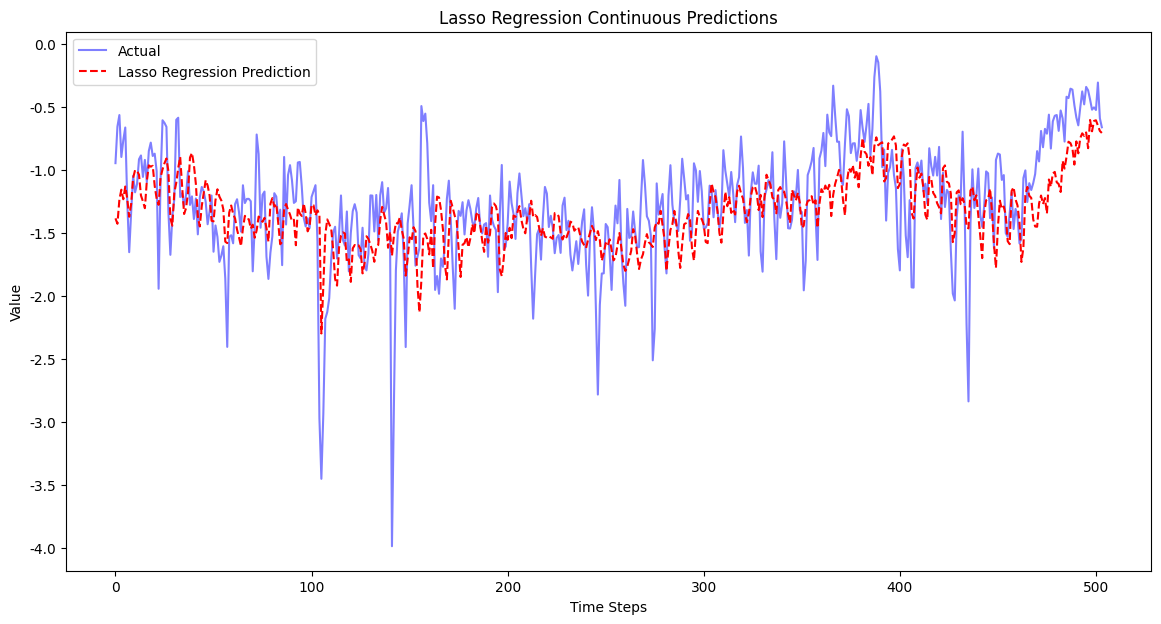

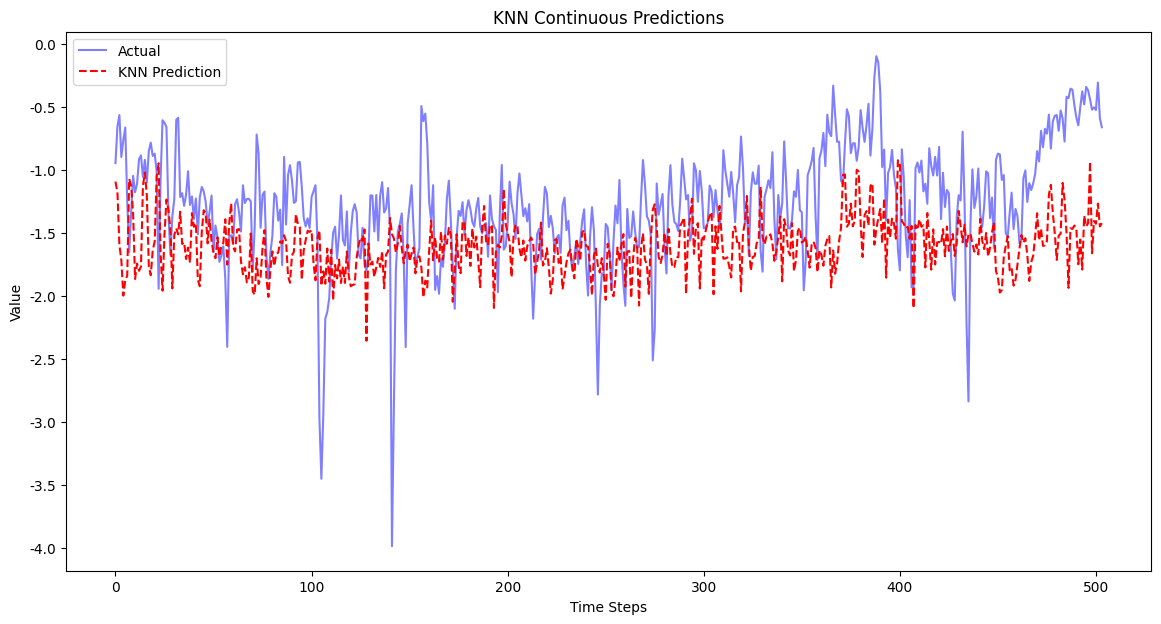

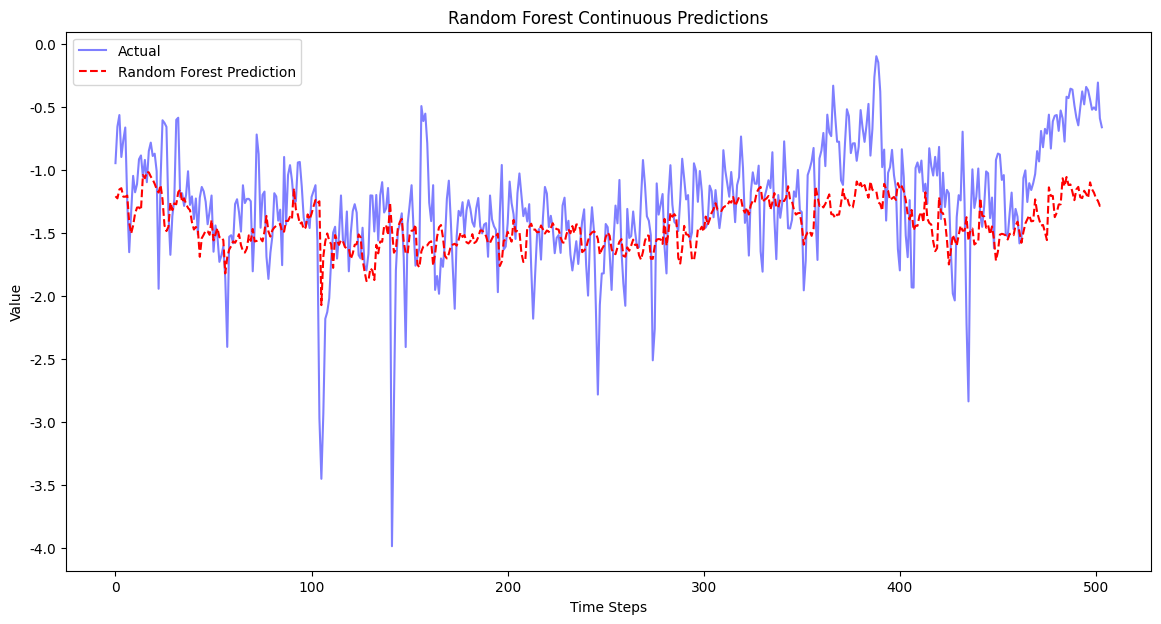

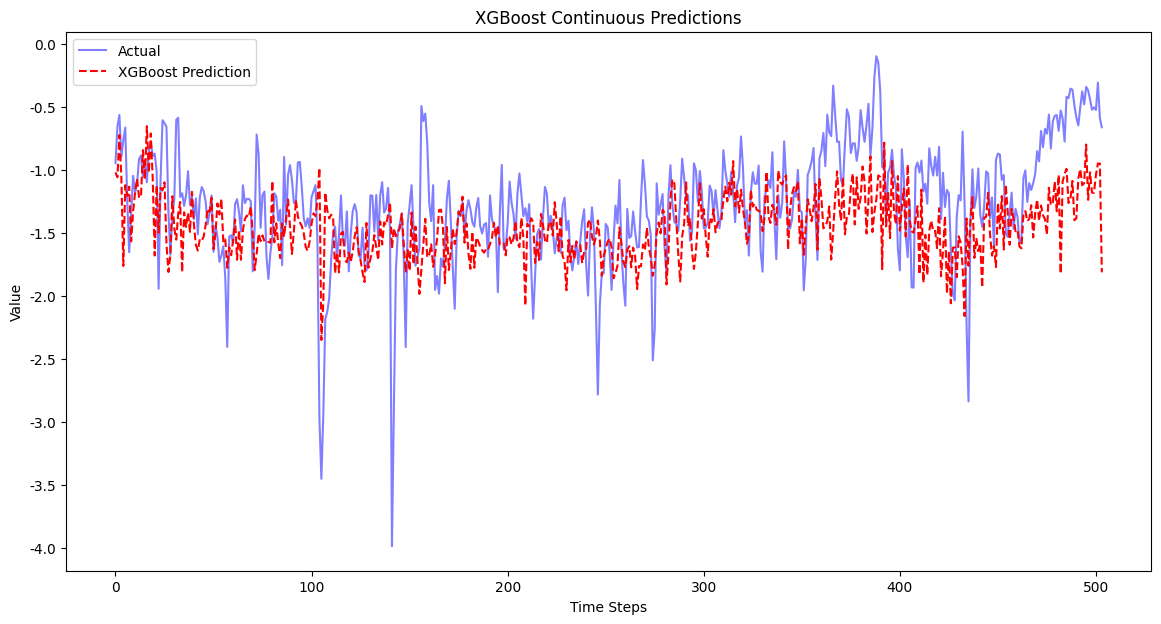

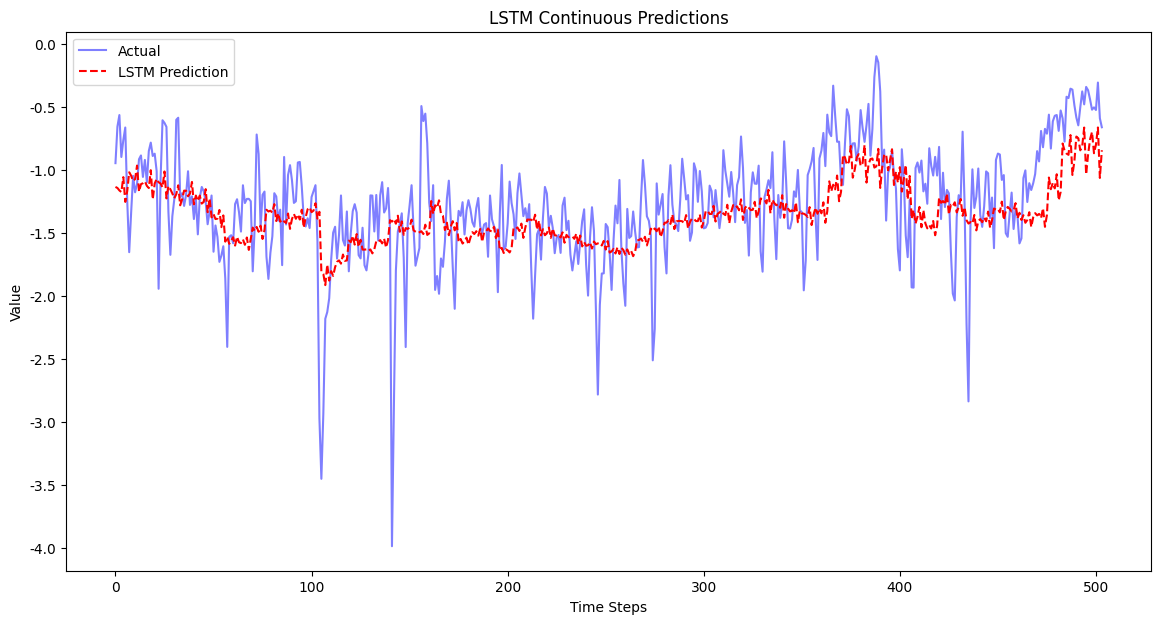

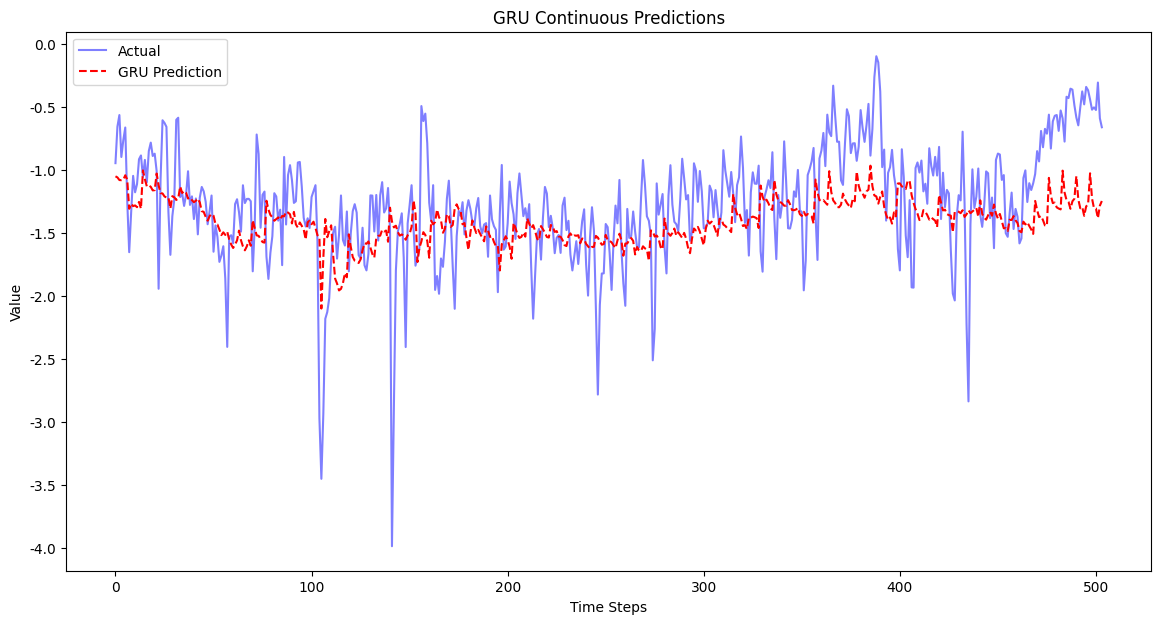

In [6]:
# 绘制特定索引的连续预测结果
def plot_continuous_predictions(y_test, predictions, model_name, forecast_steps):
    continuous_predictions = np.concatenate(predictions[::forecast_steps])
    continuous_actual = np.concatenate(y_test[::forecast_steps])
    
    plt.figure(figsize=(14, 7))
    plt.plot(continuous_actual, color='blue', label='Actual', alpha=0.5)
    plt.plot(continuous_predictions, linestyle='dashed', color='red', label=f'{model_name} Prediction')
    plt.title(f'{model_name} Continuous Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

for model_name, predictions in models.items():
    plot_continuous_predictions(y_test, predictions, model_name, forecast_steps)